In [64]:
import os
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

import utils

In [8]:
BASELINE_ELASTIC_NET_PREDS_PATH = "baseline_preds/predixcan.predictions.logtpm.csv"
LOG_TPM_COUNTS_PATH = (
    "../../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
)
NAIVE_RIDGE_PREDS_DIR = "naive_ridge_preds_maf_5e-2"
PRIOR_RIDGE_PREDS_DIR = "prior_ridge_preds_track=69,5110_maf=5e-2"

In [41]:
def compute_baseline_correlations(yri_only: bool = True):
    counts_df = pd.read_csv(LOG_TPM_COUNTS_PATH, index_col=0)  # [genes, samples]
    # Compute gene map
    gene_map = {
        index.split(".")[0]: our_gene_name
        for index, our_gene_name in zip(counts_df.index, counts_df["our_gene_name"])
    }
    counts_df = counts_df.reset_index().set_index("our_gene_name")
    counts_df = counts_df.loc[counts_df.index.dropna()]

    baseline_preds_df = pd.read_csv(
        BASELINE_ELASTIC_NET_PREDS_PATH, index_col=0
    )  # [samples, genes]
    baseline_preds_df.columns = [gene_map[g] for g in baseline_preds_df.columns]
    assert set(counts_df.index) == set(baseline_preds_df.columns)

    shared_samples = np.intersect1d(counts_df.columns, baseline_preds_df.index)
    sample_ancestries = utils.load_sample_ancestries()
    if yri_only:
        shared_samples = [s for s in shared_samples if sample_ancestries[s] == "Yoruba"]

    print(
        f"Computing cross-sample (n={len(shared_samples)}) correlations for {counts_df.shape[0]} genes"
    )

    spearmans, pearsons, r2s = {}, {}, {}
    for g in counts_df.index:
        y_true = counts_df.loc[g, shared_samples]
        y_pred = baseline_preds_df.loc[shared_samples, g]
        pearsons[g] = pearsonr(y_true, y_pred)[0]
        spearmans[g] = spearmanr(y_true, y_pred)[0]
        r2s[g] = r2_score(y_true, y_pred)

    return pearsons, spearmans, r2s

In [59]:
def get_phased_samples() -> list[str]:
    baseline_preds_df = pd.read_csv(
        BASELINE_ELASTIC_NET_PREDS_PATH, index_col=0
    )  # [samples, genes]
    return baseline_preds_df.index.tolist()

In [44]:
(
    yri_samples_elastic_net_spearmans,
    yri_samples_elastic_net_pearsons,
    yri_samples_elastic_net_r2s,
) = compute_baseline_correlations()

print(
    f"YRI samples, elastic net, spearman: {np.nanmedian(list(yri_samples_elastic_net_spearmans.values()))}"
)
print(
    f"YRI samples, elastic net, pearson: {np.nanmedian(list(yri_samples_elastic_net_pearsons.values()))}"
)
print(
    f"YRI samples, elastic net, r2: {np.nanmedian(list(yri_samples_elastic_net_r2s.values()))}"
)

Computing cross-sample (n=77) correlations for 3259 genes


/data/yosef3/scratch/ruchir/tools/mambaforge/envs/sc/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data/yosef3/scratch/ruchir/tools/mambaforge/envs/sc/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/data/yosef3/scratch/ruchir/tools/mambaforge/envs/sc/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4847: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))
/data/yosef3/scratch/ruchir/tools/mambaforge/envs/sc/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4847: NearConstantInputWarning: An input array is nearly constant; the computed correlation c

YRI samples, elastic net, spearman: 0.14768635613428704
YRI samples, elastic net, pearson: 0.14288343235711656
YRI samples, elastic net, r2: -34.30566750190806


/data/yosef3/scratch/ruchir/tools/mambaforge/envs/sc/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data/yosef3/scratch/ruchir/tools/mambaforge/envs/sc/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [69]:
phased_samples = get_phased_samples()
sample_ancestries = utils.load_sample_ancestries()
phased_yri_samples = [s for s in phased_samples if sample_ancestries[s] == "Yoruba"]

In [65]:
def compute_correlations(
    predictions_path: str, ground_truth_path: str, samples: Optional[list[str]]
):
    predictions_df = pd.read_csv(predictions_path, index_col=0)
    ground_truth_df = pd.read_csv(ground_truth_path, index_col=0)

    if samples:
        assert set(samples) - set(predictions_df.index) == set()
        assert set(samples) - set(ground_truth_df.index) == set()
    else:
        samples = np.intersect1d(predictions_df.index, ground_truth_df.index)
    shared_genes = np.intersect1d(predictions_df.columns, ground_truth_df.columns)
    print(
        f"Computing cross-sample (n={len(samples)}) correlations for {len(shared_genes)} genes"
    )

    spearmans, pearsons, r2s = {}, {}, {}
    for gene in shared_genes:
        y_true = predictions_df.loc[samples, gene]
        y_pred = ground_truth_df.loc[samples, gene]
        spearmans[gene] = spearmanr(y_true, y_pred)[0]
        pearsons[gene] = pearsonr(y_true, y_pred)[0]
        r2s[gene] = r2_score(y_true, y_pred)
    return spearmans, pearsons, r2s

In [67]:
(
    all_samples_naive_spearmans,
    all_samples_naive_pearsons,
    all_samples_naive_r2s,
) = compute_correlations(
    os.path.join(NAIVE_RIDGE_PREDS_DIR, "all_predictions.csv"),
    os.path.join(NAIVE_RIDGE_PREDS_DIR, "all_ground_truth.csv"),
    phased_samples,
)

print(
    f"All samples, naive ridge, pearson: {np.median(list(all_samples_naive_pearsons.values()))}"
)
print(
    f"All samples, naive ridge, spearman: {np.median(list(all_samples_naive_spearmans.values()))}"
)
print(
    f"All samples, naive ridge, r2: {np.median(list(all_samples_naive_r2s.values()))}"
)

Computing cross-sample (n=421) correlations for 3259 genes
All samples, naive ridge, pearson: 0.24502192836630934
All samples, naive ridge, spearman: 0.24515926711556618
All samples, naive ridge, r2: -12.106178825677835


In [70]:
(
    yri_samples_naive_spearmans,
    yri_samples_naive_pearsons,
    yri_samples_naive_r2s,
) = compute_correlations(
    os.path.join(NAIVE_RIDGE_PREDS_DIR, "yri_predictions.csv"),
    os.path.join(NAIVE_RIDGE_PREDS_DIR, "yri_ground_truth.csv"),
    phased_yri_samples,
)

print(
    f"YRI samples, naive ridge, pearson: {np.median(list(yri_samples_naive_pearsons.values()))}"
)
print(
    f"YRI samples, naive ridge, spearman: {np.median(list(yri_samples_naive_spearmans.values()))}"
)
print(
    f"YRI samples, naive ridge, r2: {np.median(list(yri_samples_naive_r2s.values()))}"
)

Computing cross-sample (n=77) correlations for 3259 genes
YRI samples, naive ridge, pearson: 0.15585277325502933
YRI samples, naive ridge, spearman: 0.15234765234765235
YRI samples, naive ridge, r2: -27.905810450593098


In [71]:
(
    all_samples_prior_spearmans,
    all_samples_prior_pearsons,
    all_samples_prior_r2s,
) = compute_correlations(
    os.path.join(PRIOR_RIDGE_PREDS_DIR, "all_predictions.csv"),
    os.path.join(PRIOR_RIDGE_PREDS_DIR, "all_ground_truth.csv"),
    phased_samples,
)

print(
    f"All samples, prior ridge, pearson: {np.median(list(all_samples_prior_pearsons.values()))}"
)
print(
    f"All samples, prior ridge, spearman: {np.median(list(all_samples_prior_spearmans.values()))}"
)
print(
    f"All samples, prior ridge, r2: {np.median(list(all_samples_prior_r2s.values()))}"
)

Computing cross-sample (n=421) correlations for 3259 genes
All samples, prior ridge, pearson: 0.2556612497272532
All samples, prior ridge, spearman: 0.25340012629922193
All samples, prior ridge, r2: -11.599436184304638


In [73]:
(
    yri_samples_prior_spearmans,
    yri_samples_prior_pearsons,
    yri_samples_prior_r2s,
) = compute_correlations(
    os.path.join(PRIOR_RIDGE_PREDS_DIR, "yri_predictions.csv"),
    os.path.join(PRIOR_RIDGE_PREDS_DIR, "yri_ground_truth.csv"),
    phased_yri_samples,
)

print(
    f"YRI samples, prior ridge, pearson: {np.median(list(yri_samples_prior_pearsons.values()))}"
)
print(
    f"YRI samples, prior ridge, spearman: {np.median(list(yri_samples_prior_spearmans.values()))}"
)
print(
    f"YRI samples, prior ridge, r2: {np.median(list(yri_samples_prior_r2s.values()))}"
)

Computing cross-sample (n=77) correlations for 3259 genes
YRI samples, prior ridge, pearson: 0.17000113800824282
YRI samples, prior ridge, spearman: 0.1654924023345076
YRI samples, prior ridge, r2: -24.973167208983767


In [78]:
def compare_correlations(
    corrs1: dict, corrs2: dict, xlabel: str, ylabel: str, title: str, ax: plt.Axes
):
    genes = list(set(corrs1.keys()) & set(corrs2.keys()))
    corrs1_l = np.asarray([corrs1[g] for g in genes])
    corrs2_l = np.asarray([corrs2[g] for g in genes])

    n_corrs1_better = np.sum((corrs1_l >= corrs2_l) | np.isnan(corrs2_l))
    n_corrs2_better = np.sum((corrs2_l > corrs1_l) | np.isnan(corrs1_l))

    sns.scatterplot(x=corrs1_l, y=corrs2_l, s=20, alpha=0.5, ax=ax)
    ax.set_xlabel(xlabel + "\n" + rf"$\mu={np.nanmean(corrs1_l):.3f}$")
    ax.set_ylabel(ylabel + "\n" + rf"$\mu={np.nanmean(corrs2_l):.3f}$")
    ax.set_title(title)

    # Plot diagonal line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect("equal")

    # Plot number of genes where each method is better
    pct_corrs1_better = n_corrs1_better / len(genes) * 100.0
    pct_corrs2_better = n_corrs2_better / len(genes) * 100.0
    ax.text(
        x=0.95,
        y=0.05,
        s=f"{n_corrs1_better}/{len(genes)} ({pct_corrs1_better:.1f}%)",
        c="red",
        transform=ax.transAxes,
        ha="right",
        va="bottom",
    )
    ax.text(
        x=0.05,
        y=0.95,
        s=f"{n_corrs2_better}/{len(genes)} ({pct_corrs2_better:.1f}%)",
        c="red",
        transform=ax.transAxes,
        ha="left",
        va="top",
    )

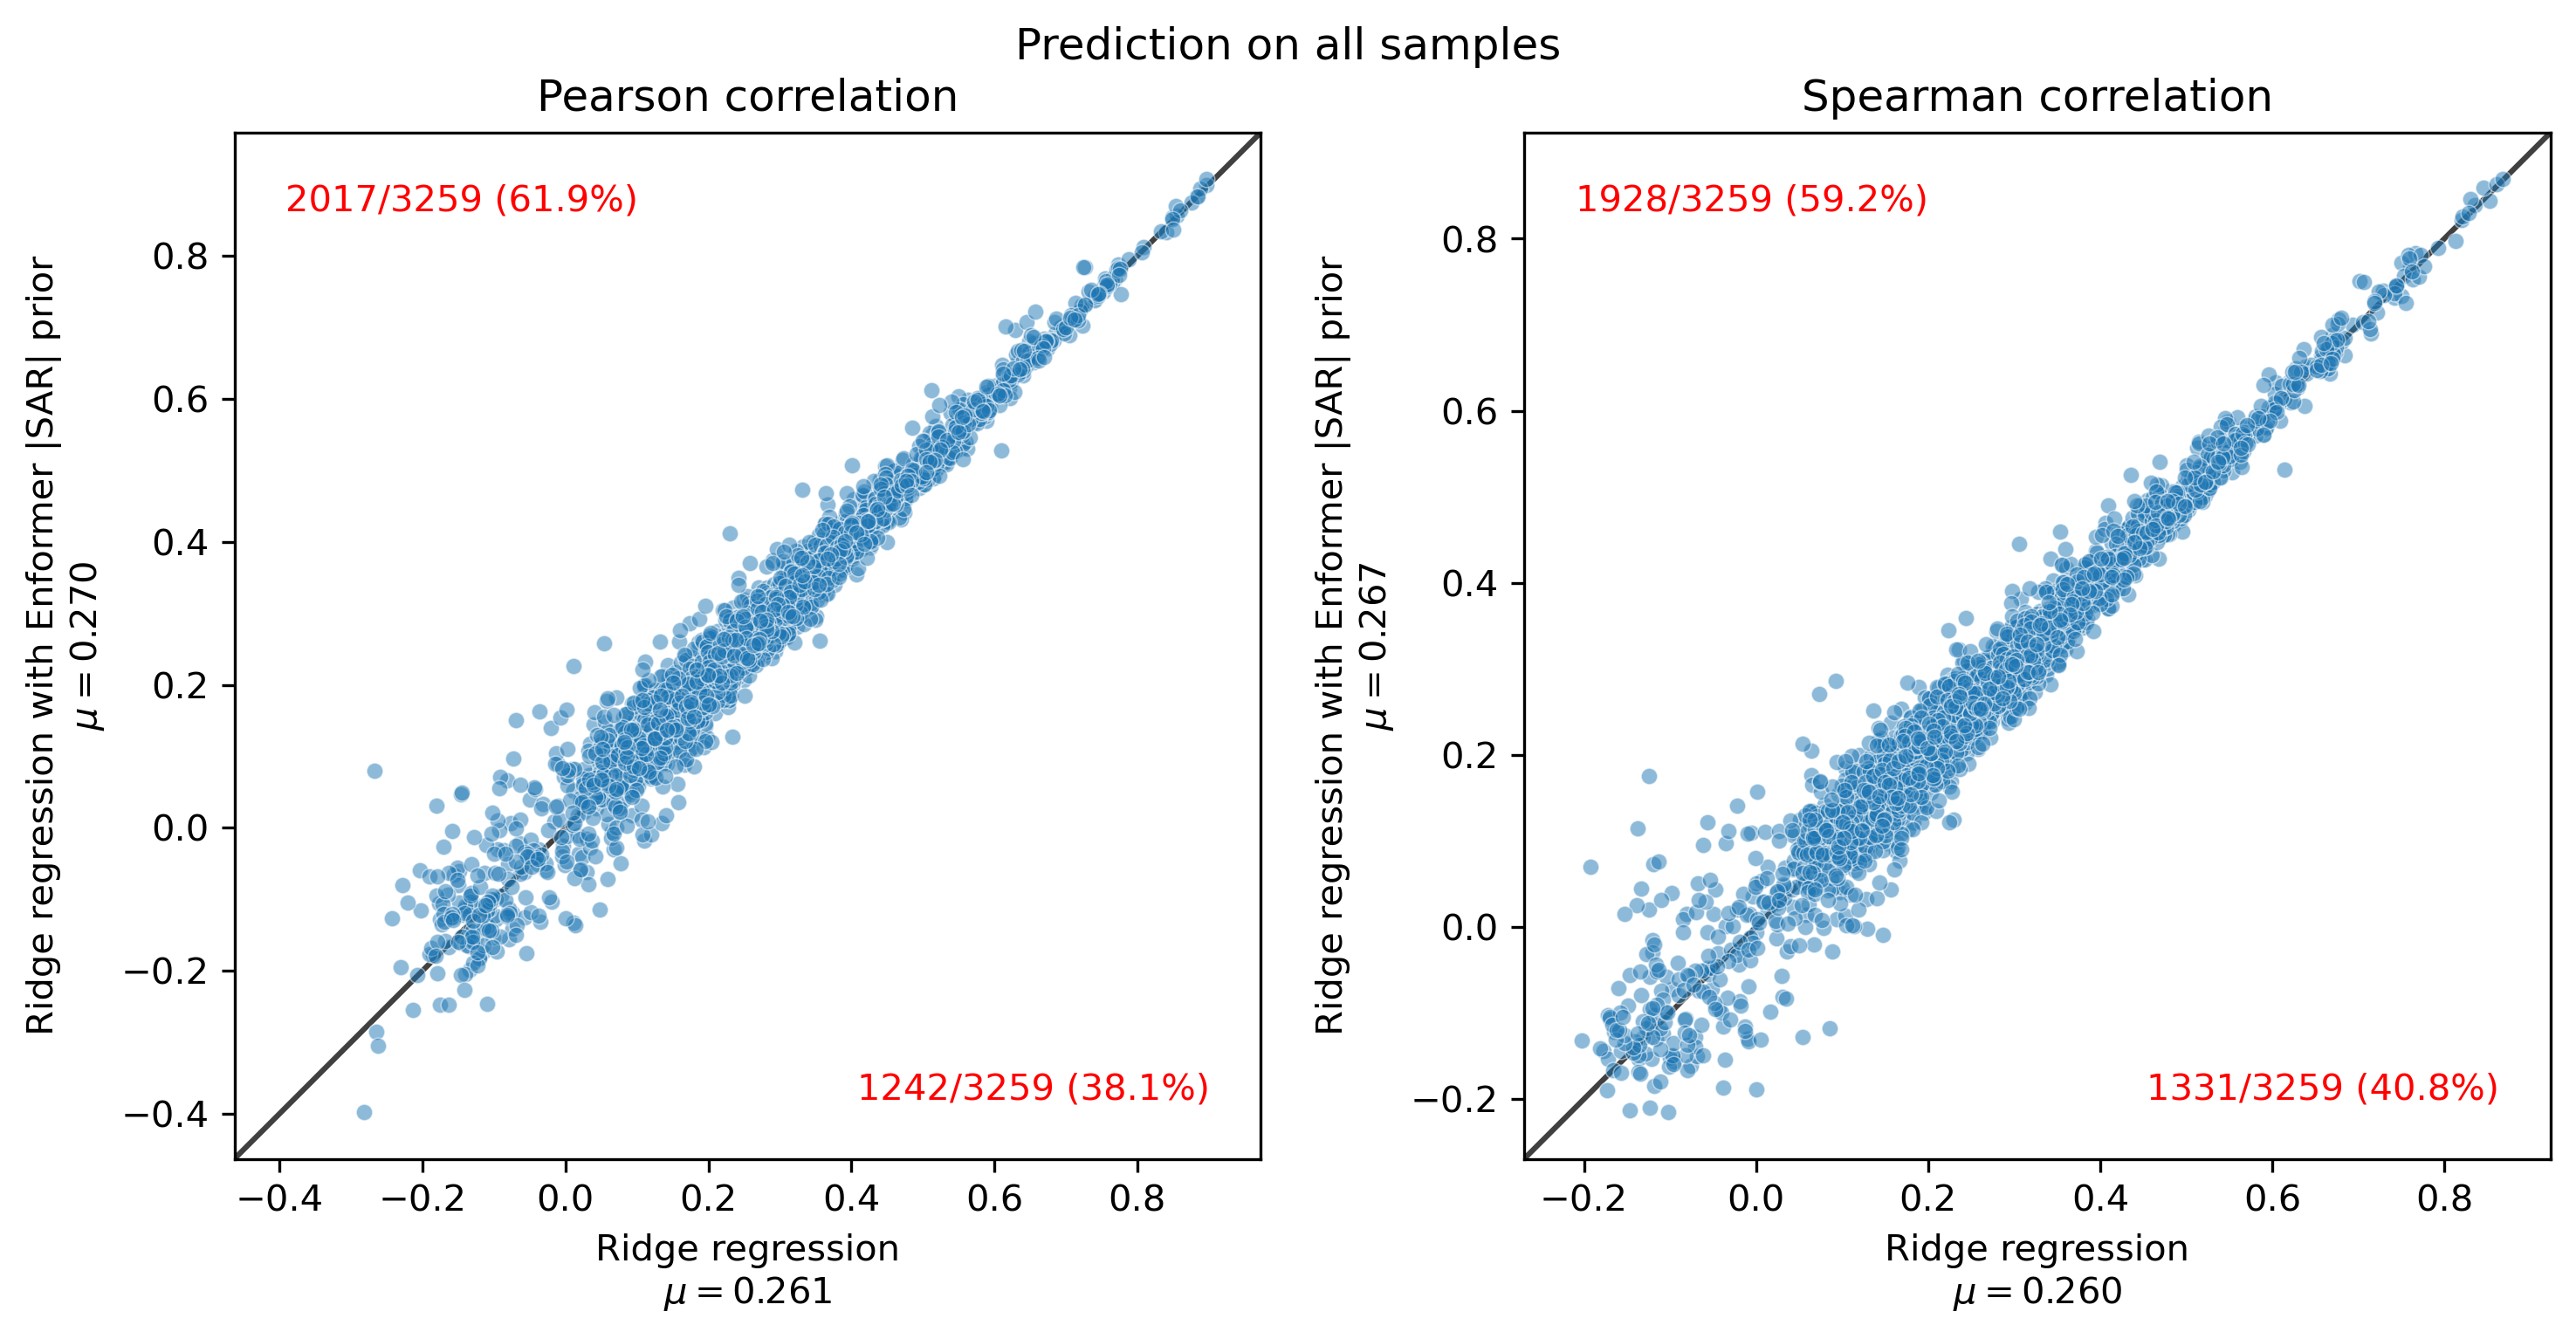

In [75]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), dpi=300)
compare_correlations(
    all_samples_naive_pearsons,
    all_samples_prior_pearsons,
    "Ridge regression",
    "Ridge regression with Enformer |SAR| prior",
    "Pearson correlation",
    axs[0],
)
compare_correlations(
    all_samples_naive_spearmans,
    all_samples_prior_spearmans,
    "Ridge regression",
    "Ridge regression with Enformer |SAR| prior",
    "Spearman correlation",
    axs[1],
)
plt.suptitle("Prediction on all samples")
plt.tight_layout()
plt.show()

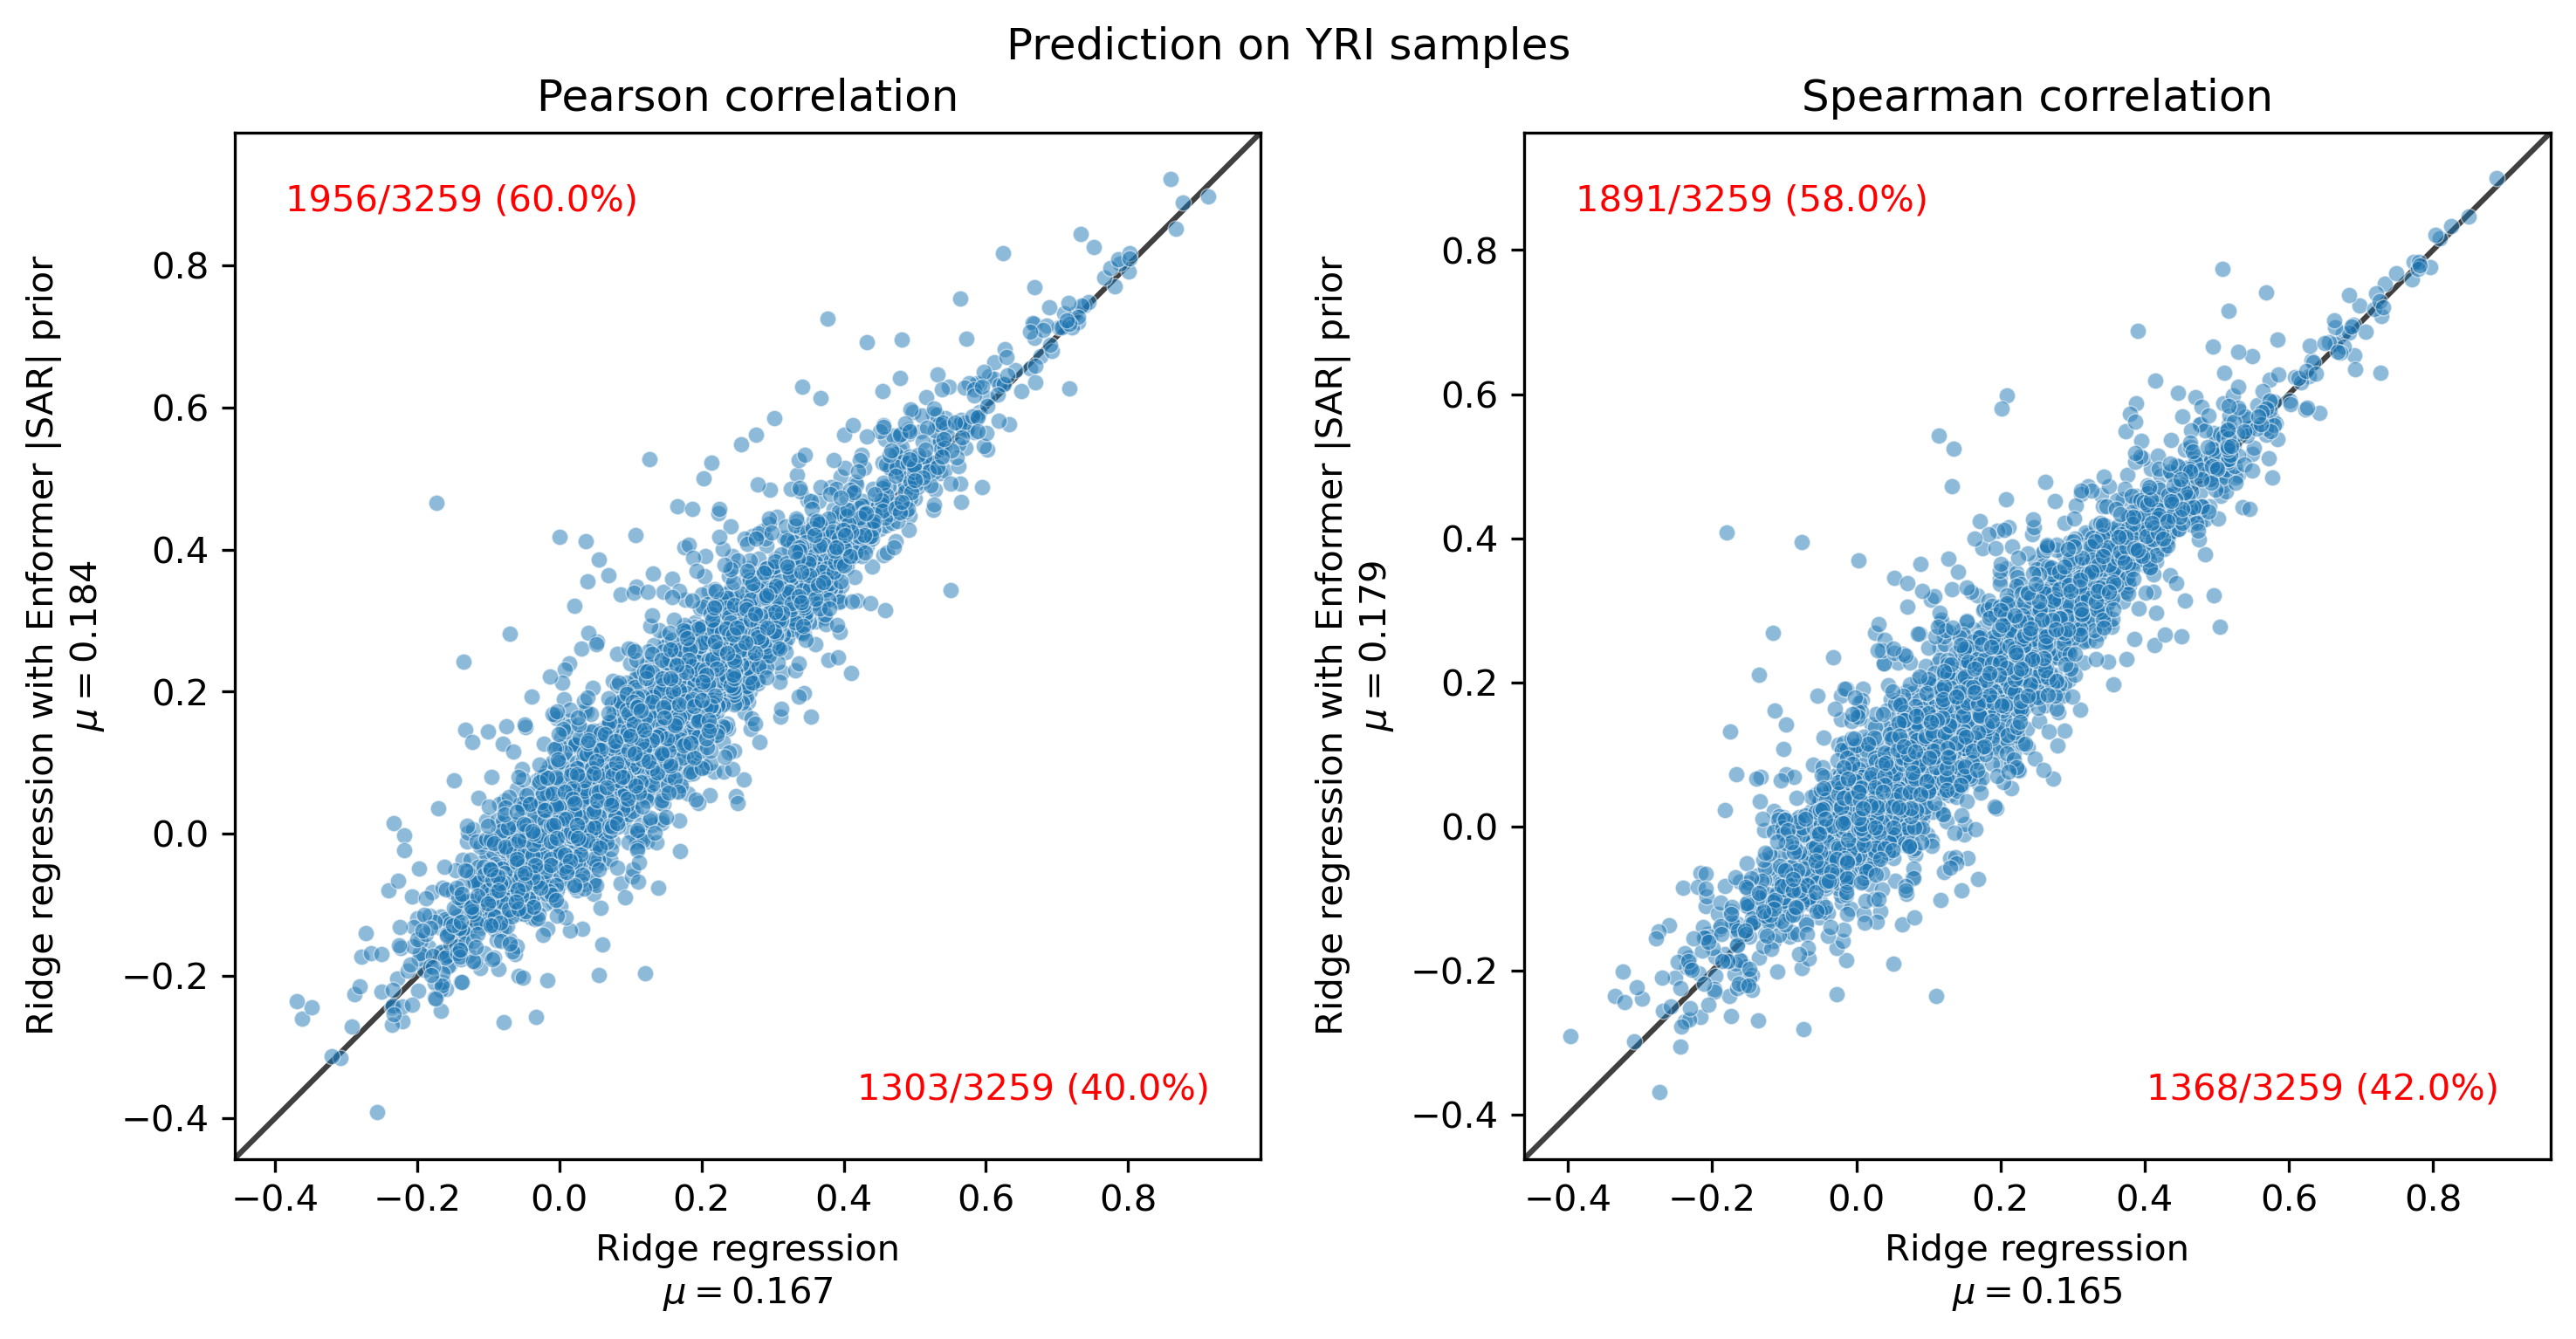

In [76]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), dpi=300)
compare_correlations(
    yri_samples_naive_pearsons,
    yri_samples_prior_pearsons,
    "Ridge regression",
    "Ridge regression with Enformer |SAR| prior",
    "Pearson correlation",
    axs[0],
)
compare_correlations(
    yri_samples_naive_spearmans,
    yri_samples_prior_spearmans,
    "Ridge regression",
    "Ridge regression with Enformer |SAR| prior",
    "Spearman correlation",
    axs[1],
)
plt.suptitle("Prediction on YRI samples")
plt.tight_layout()
plt.show()

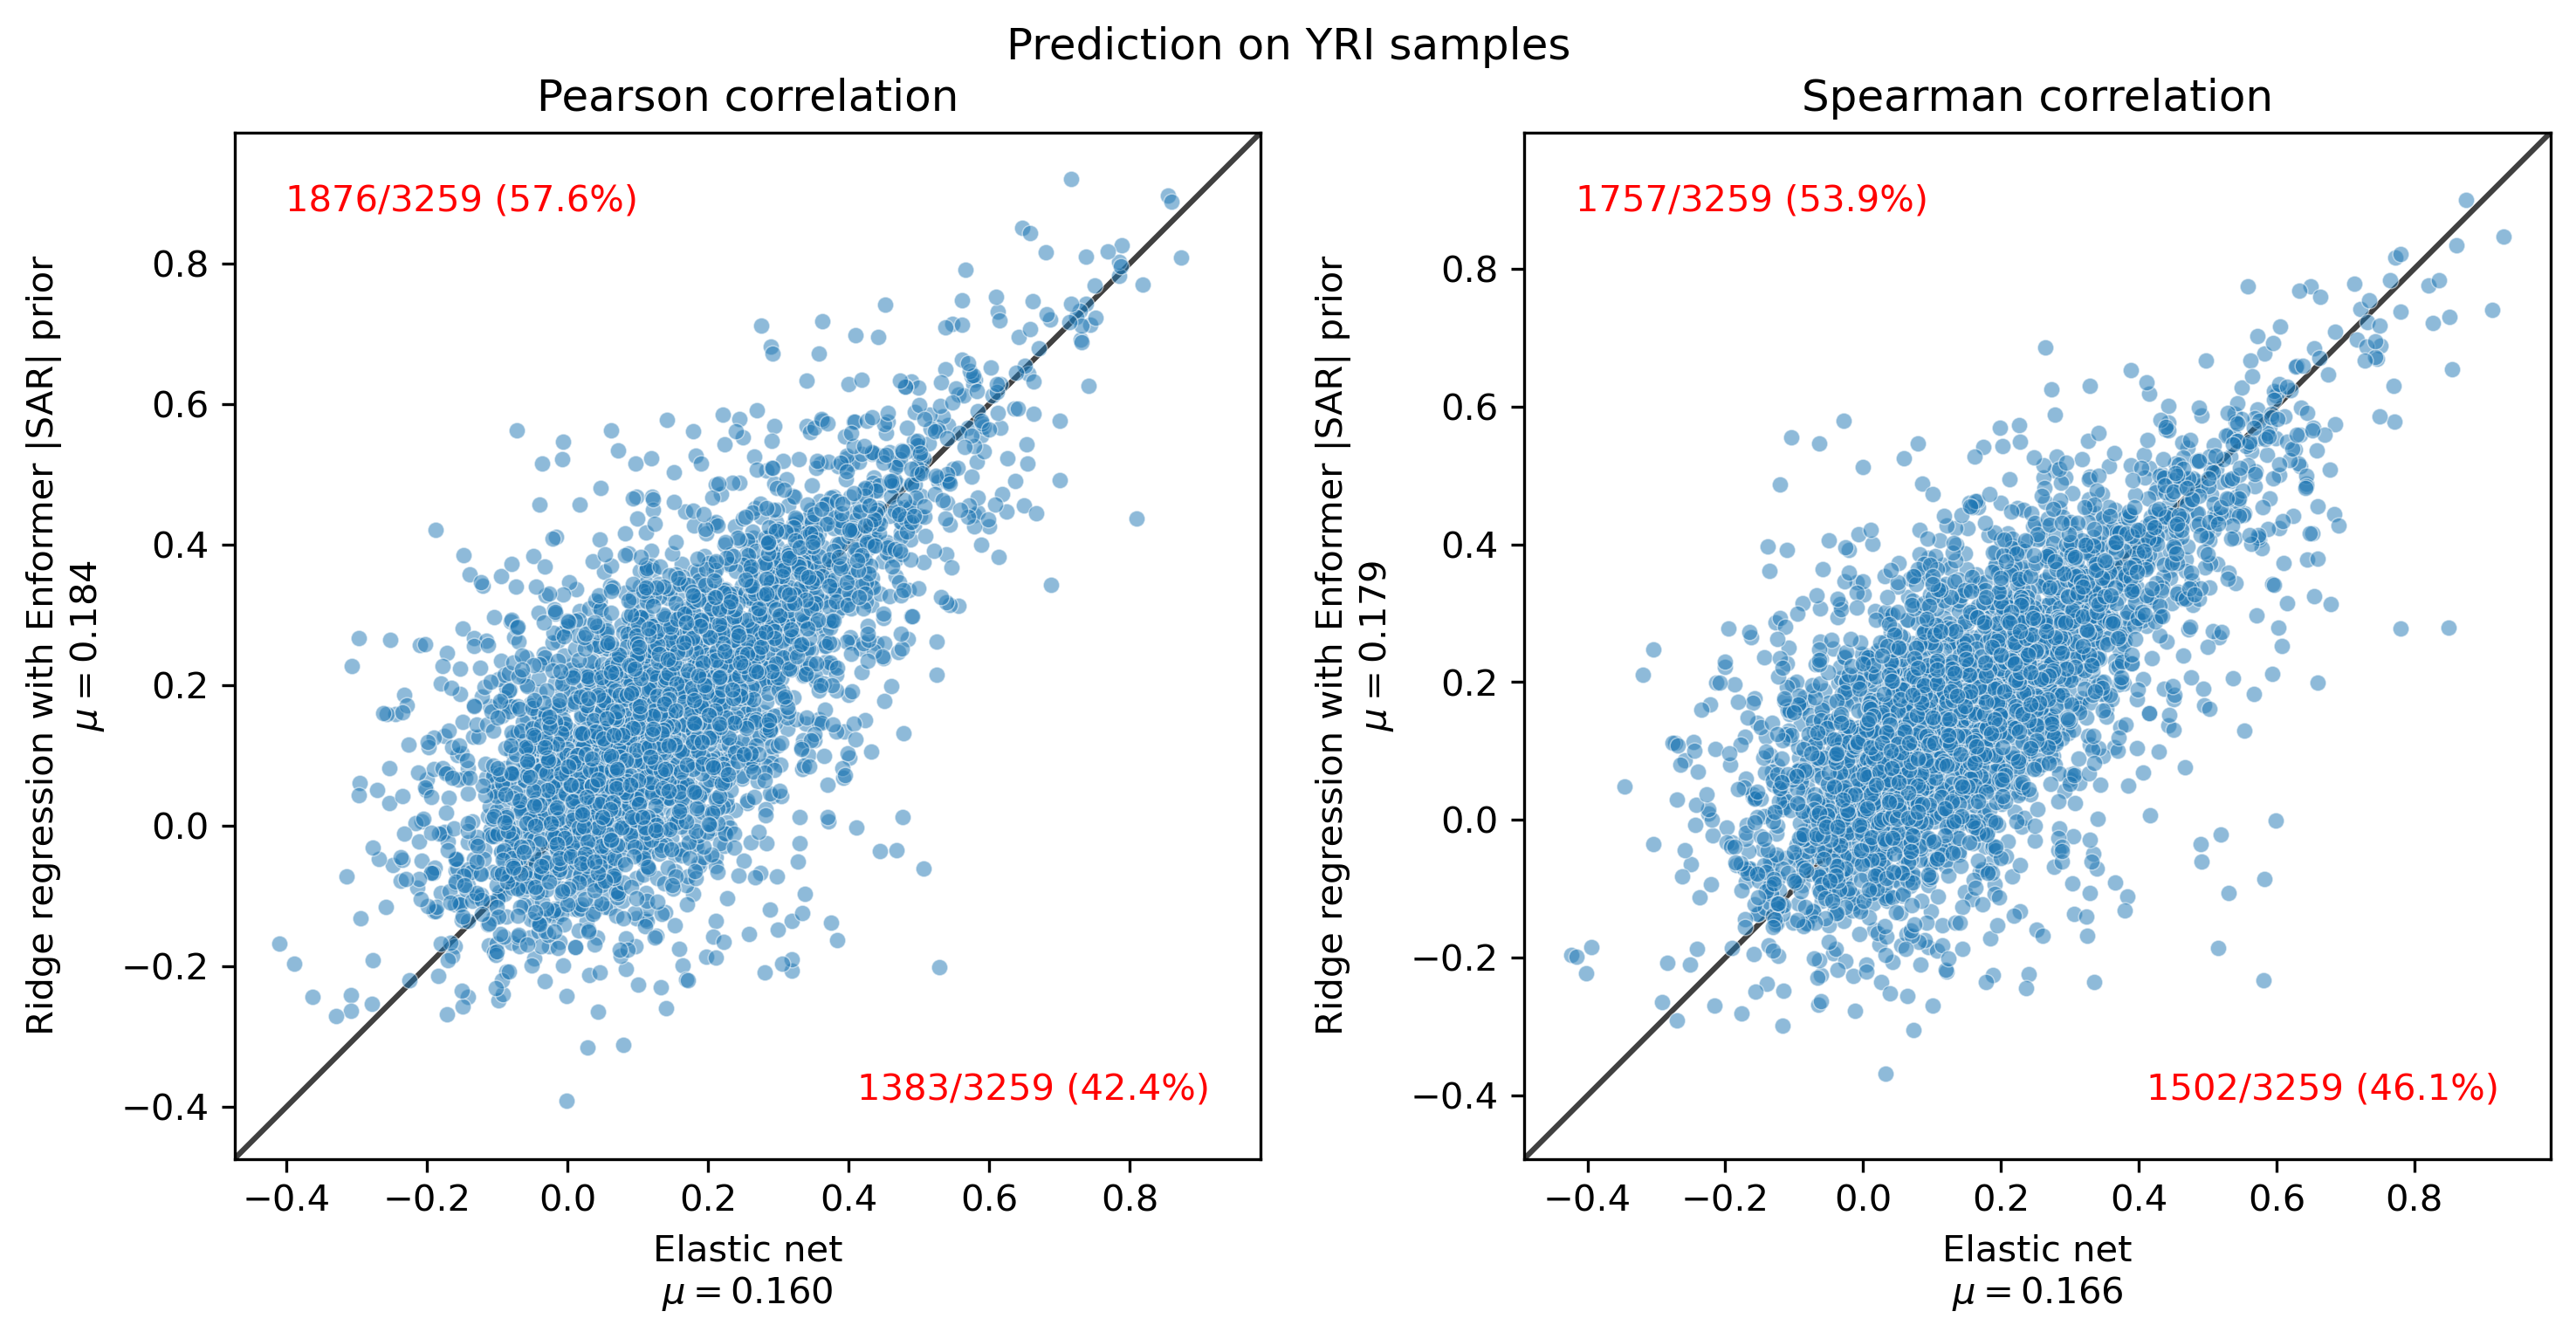

In [79]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), dpi=300)
compare_correlations(
    yri_samples_elastic_net_pearsons,
    yri_samples_prior_pearsons,
    "Elastic net",
    "Ridge regression with Enformer |SAR| prior",
    "Pearson correlation",
    axs[0],
)
compare_correlations(
    yri_samples_elastic_net_spearmans,
    yri_samples_prior_spearmans,
    "Elastic net",
    "Ridge regression with Enformer |SAR| prior",
    "Spearman correlation",
    axs[1],
)
plt.suptitle("Prediction on YRI samples")
plt.tight_layout()
plt.show()